# *Lipomyces starkeyi* medium optimization round 2 - part B.

This notebook leverages ART to identify conditions for testing during a second round of medium optimization. The round was split into two different ART training notebooks - parts A and parts B. This is **part B**.

Medium components have a profound impact on production of microbial products. The effects of metals and vitamins on *L. starkeyi* malic acid production has been explored in a limited capacity - with the full composition space remaining to be explored. The Automated Recommendation Tool ([ART](https://www.nature.com/articles/s41467-020-18008-4)) is a machine learning based tool for bioproduction applications. The tool has been designed to provide both initial design of experiment and recommendations for further designs. The algorithm uses [Latin Hypercube Sampling](https://en.wikipedia.org/wiki/Latin_hypercube_sampling) to combinatorally explore the initial design space. A media optimization pipeline has been described using ART ([Zournas A et al., 2024: DOI: 10.21203/rs.3.rs-5072705/v1](https://www.researchsquare.com/article/rs-5072705/v1) that is leveraged here. 

This notebook leverages ART to identify additional explore conditions for testing during a second round of medium optimization. The notebook uses the DBTL1 and DBTL2 conditions (NOT results) to train a model, and then uses the newly trained model for exploration of the medium space.

## Inputs and Outputs

**Required files to run this notebook:**
- `bounds_file_DBTL2.csv` - Contains the boundaries to explore.
- `standard_media_file.csv` - Contains the medium components.
- `combinedResults_DBTL1and2.csv` - Round 1 results and round 2 conditions/data.

Clone the git repository with the `ART` library 

`git clone https://github.com/JBEI/AutomatedRecommendationTool.git`  
<!-- <font color='red'> _____ -->
<!-- **WE SHOULD TALK ABOUT LICENSING HERE!!!** </font> -->

or pull the latest version. 

Information about licensing ART is available at https://github.com/JBEI/ART.

Importing needed libraries:

In [35]:
import sys
sys.path.append('../../AutomatedRecommendationTool')        # Make sure this is the location for the ART library 
sys.path.append('../')

import re
import warnings

import matplotlib.pyplot as plt
# from art.core import designs_pairwise/
from art.core import * 
import art.plot as plot
import edd_utils as eddu

import os


In [36]:
# from art.core import designs_pairwise

# User parameters

In [37]:
CYCLE = 2

user_params = {
    # file containing the lower and upper bounds to explore. 
    #'bounds_file': f'mediumSetup/bounds_file.csv',
    'bounds_file': f'mediumSetup/bounds_file_DBTL2.csv',

    
    
    # folder for output files.
    'output_file_path': f'mediumConcentrationOutputs/DBTL_2_partB_explore{CYCLE}', 
    
    # folder containing the standard media file. 
    # for Lipomyces - this is the LPM-40-50 (lipid production medium - 40 g carbon, 50 C/N ratio).
    'standard_media_file': f'mediumSetup/standard_media_file.csv',
    
    
}

In [38]:
user_params['components'] = [
        #'glucose',
        #'xylose',
        'KH2PO4',
        'NH4Cl',
        'KCl',
        'MgSO4*7H2O',
        'ZnSO4·7H2O',
        'H3BO3',
        'MnCl2·4H2O',
        'FeSO4·7H2O',
        'CoCl2·6H2O',
        'CuSO4·5H20',
        'Na2MoO4·2H2O',
        'Na4EDTA',
        'biotin',
        'pyridoxine',
        'thiamine',
        'riboflavin',
        'para-aminobenzoic acid',
        'nicotinic acid'
]

In [39]:
user_params['response'] = 'Malate Titer (g/L)'

# Load the data

In [40]:
DBTL_results = pd.read_csv('experimentalResults/DBTL2_results/dummyResults_DBTL1and2.csv')
DBTL_results.rename(columns={'Unnamed: 0': 'Line Name'},inplace=True)

# col_drop = np.arange(0,75) # drop all except control from dbtl 1a
# DBTL1_results.drop(col_drop,inplace=True)
DBTL_results.tail(4)

,Line Name,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,...,Na2MoO4·2H2O,Na4EDTA,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid,Malate Titer (g/L),DCW (g/L)
257,22c,4.619793,3.180391,3.814341,0.280609,0.237304,0.879325,0.435048,0.354152,0.088065,...,0.089010,2.058640,0.009972,0.009589,0.003318,0.018708,0.001813,0.006659,1.0,1.0
258,24c,4.291071,4.091897,1.321019,0.299799,0.411875,0.080135,0.468360,0.114329,0.357079,...,0.069739,0.913847,0.008394,0.000311,0.002309,0.044397,0.006925,0.005050,1.0,1.0
259,24c,4.291071,4.091897,1.321019,0.299799,0.411875,0.080135,0.468360,0.114329,0.357079,...,0.069739,0.913847,0.008394,0.000311,0.002309,0.044397,0.006925,0.005050,1.0,1.0
260,24c,4.291071,4.091897,1.321019,0.299799,0.411875,0.080135,0.468360,0.114329,0.357079,...,0.069739,0.913847,0.008394,0.000311,0.002309,0.044397,0.006925,0.005050,1.0,1.0


In [41]:
# add the replicate indicator (Replicate 1 = -R1, Replicate 2 = '-R2', etc) to each line name.

DBTL_results['Line Name'][0::3] = DBTL_results['Line Name'][0::3].astype(str)+'-R1'
DBTL_results['Line Name'][1::3] = DBTL_results['Line Name'][1::3].astype(str)+'-R2'
DBTL_results['Line Name'][2::3] = DBTL_results['Line Name'][2::3].astype(str)+'-R3'

In [42]:
DBTL_results.tail(6)

,Line Name,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,...,Na2MoO4·2H2O,Na4EDTA,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid,Malate Titer (g/L),DCW (g/L)
255,22c-R1,4.619793,3.180391,3.814341,0.280609,0.237304,0.879325,0.435048,0.354152,0.088065,...,0.089010,2.058640,0.009972,0.009589,0.003318,0.018708,0.001813,0.006659,1.0,1.0
256,22c-R2,4.619793,3.180391,3.814341,0.280609,0.237304,0.879325,0.435048,0.354152,0.088065,...,0.089010,2.058640,0.009972,0.009589,0.003318,0.018708,0.001813,0.006659,1.0,1.0
257,22c-R3,4.619793,3.180391,3.814341,0.280609,0.237304,0.879325,0.435048,0.354152,0.088065,...,0.089010,2.058640,0.009972,0.009589,0.003318,0.018708,0.001813,0.006659,1.0,1.0
258,24c-R1,4.291071,4.091897,1.321019,0.299799,0.411875,0.080135,0.468360,0.114329,0.357079,...,0.069739,0.913847,0.008394,0.000311,0.002309,0.044397,0.006925,0.005050,1.0,1.0
259,24c-R2,4.291071,4.091897,1.321019,0.299799,0.411875,0.080135,0.468360,0.114329,0.357079,...,0.069739,0.913847,0.008394,0.000311,0.002309,0.044397,0.006925,0.005050,1.0,1.0
260,24c-R3,4.291071,4.091897,1.321019,0.299799,0.411875,0.080135,0.468360,0.114329,0.357079,...,0.069739,0.913847,0.008394,0.000311,0.002309,0.044397,0.006925,0.005050,1.0,1.0


Define the controls. In DBTL 1 and 2, controls were samples 25. 

In [43]:
# control_lines = DBTL1_results[DBTL1_results['Line Name'].str.find('25')>-1]
control_lines = DBTL_results[DBTL_results['Line Name'].str.find('25a')>-1]
control_lines

,Line Name,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,...,Na2MoO4·2H2O,Na4EDTA,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid,Malate Titer (g/L),DCW (g/L)
75,25a-R1,1.5,1.43,0.5,0.5,0.00225,0.011,0.005,0.005,0.0017,...,0.000085,0.005,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,10.54,13.780
76,25a-R2,1.5,1.43,0.5,0.5,0.00225,0.011,0.005,0.005,0.0017,...,0.000085,0.005,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,10.92,12.940
77,25a-R3,1.5,1.43,0.5,0.5,0.00225,0.011,0.005,0.005,0.0017,...,0.000085,0.005,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,10.63,17.236


How many designs imporved the response over the standard recipe?

In [44]:
control_response = np.mean(control_lines['Malate Titer (g/L)'])
num_improved_response = np.sum(DBTL_results['Malate Titer (g/L)'] > control_response)
num_designs = len(DBTL_results) - len(control_lines)
print(f'{num_improved_response} samples out of {num_designs} improve over the standard in terms of Titer ({num_improved_response/num_designs*100:.2f})%')

4 samples out of 258 improve over the standard in terms of Titer (1.55)%


## Convert the data to EDD format for ART input.

Pivot the dataframe to [Experimental Data Depot format](https://edd-docs.jbei.org/), inlcuding all components names and protocols:

In [45]:
DBTL_stacked = DBTL_results.set_index('Line Name').stack().reset_index()
DBTL_stacked.columns = ['Line Name', 'Measurement Type', 'Value']
DBTL_stacked.head()

,Line Name,Measurement Type,Value
0,0a-R1,KH2PO4,3.980770
1,0a-R1,NH4Cl,2.726696
2,0a-R1,KCl,3.101909
3,0a-R1,MgSO4*7H2O,3.564820
4,0a-R1,ZnSO4·7H2O,0.342065


In [12]:
# DBTL_stacked.csv('DBTL1&2EDDformatedResults.csv')

# Media designs recommendations

## ART parameter setup

Define a dictionary that contains the settings ART will use to find the recommended designs:


In [13]:
art_params = {
    'input_vars': user_params['components'],
    'response_vars': [user_params['response']],
    'bounds_file': user_params['bounds_file'], # file with bounds for input variables (i.e., features)
    'seed': 12,
    'cross_val': True,
    'recommend': False,
    'output_directory': user_params['output_file_path'],
    'verbose': 0,
    'max_mcmc_cores':4
}

We will first run only the model building part and then proceed with optimization using the two modes - exploration and explotation.

In [50]:
user_params['alpha_explor'] = 1.0
user_params['alpha_exploit'] = None

Here we specify how many instances (design) we want to create and how many replicates:


In [54]:
user_params['n_instances_explore'] = 10
user_params['n_instances_exploit'] = 13
user_params['n_replicates'] = 3

with the configuration now stored in art_params, we now run ART:

## Initialize and Train ART

In [16]:
run_art = True

Dataframe does not have a time column matching one of the supported formats. Assuming that all data in the file comes from a single time point.
Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omegas, sigma]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 17 seconds.
Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omegas, sigma]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 13 seconds.
The number of effective samples is smaller than 25% for some parameters.
Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omegas, sigma]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 27 seconds.


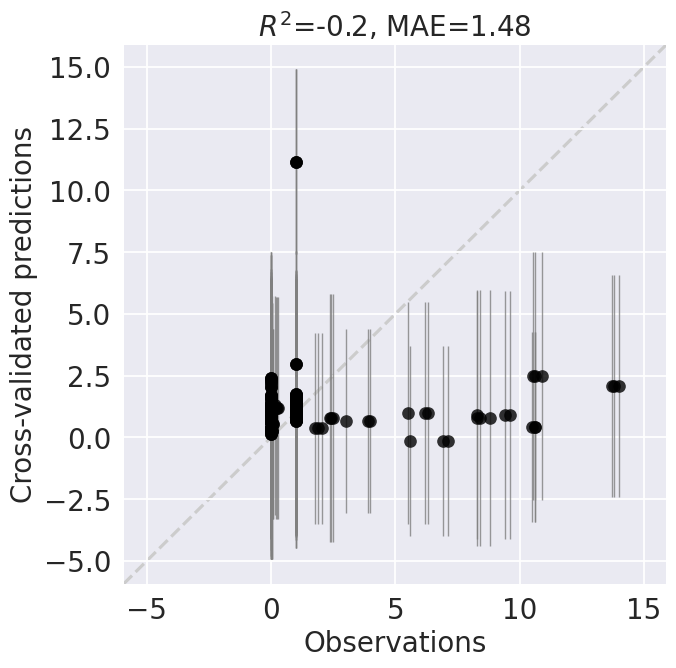

Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omegas, sigma]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 29 seconds.
The number of effective samples is smaller than 10% for some parameters.


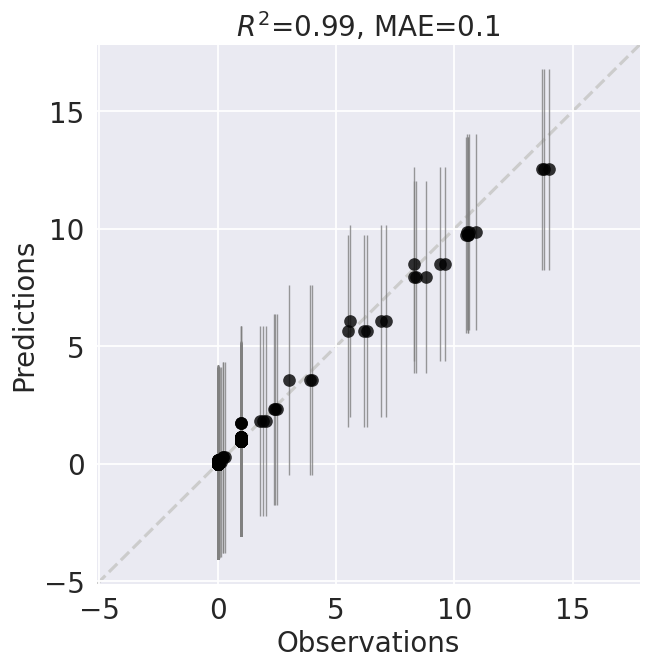

CPU times: user 20min 29s, sys: 9.95 s, total: 20min 39s
Wall time: 23min 16s


In [46]:
%%time
warnings.filterwarnings("ignore")
if run_art:
    art = RecommendationEngine(DBTL_stacked, **art_params)
else:
    with open(os.path.join(art_params['output_directory'], 'art.pkl'), 'rb') as output:
        art = pickle.load(output)

In [47]:
art.evaluate_models_cv()

,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,1.986814,inf,2.520749,10.301607,-0.559690
Random Forest Regressor,1.657181,inf,2.476278,8.878200,-0.344183
Support Vector Regressor,1.194477,inf,2.350644,6.952304,-0.052597
Kernel Ridge Regressor,1.335294,inf,2.202611,6.634505,-0.004481
K-NN Regressor,1.860031,NaN,2.779361,11.184562,-0.693372
Gaussian Process Regressor,1.530941,inf,2.400674,8.107016,-0.227423
Gradient Boosting Regressor,1.739073,inf,2.840394,11.092213,-0.679390
TPOT Regressor,1.640600,NaN,2.499284,8.937986,-0.353234
Ensemble Model,1.479690,inf,2.396304,7.931755,-0.200888


## Exploration recommendations

In [51]:


%%time
art.niter = 100000
art.alpha = user_params['alpha_explor']
draws = art.parallel_tempering_opt()



CPU times: user 281 ms, sys: 26.3 ms, total: 307 ms
Wall time: 3min 44s


In [52]:
orig_file_name = f"{art_params['output_directory']}/draws.txt"
new_file_name = f"{art_params['output_directory']}/draws_explor.txt"
os.rename(orig_file_name, new_file_name)



In [55]:
art.num_recommendations = user_params['n_instances_explore']
art.rel_rec_distance = 3.0
art.recommend(draws)

# At least one of the features in the recommendation must differ by this relative factor from any point in the training data and any previous recommendations
# Then pick the one with the best objective function value and add to the recommendations. Repeat the distance filtering above. 
# Stops when 7 recommendations are found.

# If it cannot find enough recommendations, it will decrease the distance by 0.80x and try again.

In [56]:
df_rec_explor = art.recommendations.copy()

In [57]:
df_rec_explor

,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,CuSO4·5H20,Na2MoO4·2H2O,Na4EDTA,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid,Malate Titer (g/L)
0,4.715872,0.835929,4.557331,1.953778,0.283068,0.877251,0.139454,0.142752,0.074789,0.466199,0.018275,1.555209,0.008293,0.001365,0.001448,0.021424,0.003865,0.009016,0.567682
1,3.307102,2.127971,2.864732,1.299409,0.456020,0.043591,0.394603,0.275901,0.240586,0.407918,0.000745,2.042558,0.004222,0.005046,0.007061,0.008861,0.003591,0.009693,0.961562
2,4.600939,2.277247,4.382520,1.241922,0.311666,0.653661,0.182087,0.172074,0.408142,0.417694,0.012842,1.287714,0.009533,0.003658,0.004089,0.009239,0.008680,0.006855,0.640354
3,0.712971,1.701991,4.140557,2.203677,0.324425,0.477065,0.455215,0.077644,0.026307,0.123170,0.097264,2.479637,0.004467,0.004596,0.000621,0.028608,0.004911,0.004515,3.519268
4,4.385339,3.862647,0.638906,1.104319,0.437863,0.790959,0.193977,0.339253,0.298684,0.468898,0.075963,2.012968,0.004430,0.001261,0.005332,0.000109,0.008959,0.008239,3.293892
5,1.472850,0.808603,2.208736,2.665660,0.001284,0.513783,0.227719,0.454090,0.049220,0.149756,0.024872,2.381946,0.000641,0.005724,0.003904,0.045972,0.003627,0.009648,0.835062
6,0.454033,0.696805,3.368887,4.003595,0.240726,0.292176,0.461282,0.110994,0.216912,0.432028,0.084510,2.370167,0.008757,0.008620,0.004676,0.047503,0.009078,0.003057,3.425689
7,2.689874,1.584316,2.622409,3.297719,0.072180,0.266914,0.245467,0.266466,0.304795,0.056756,0.001108,1.550928,0.004105,0.004463,0.009506,0.039201,0.003596,0.007191,1.187320
8,0.662274,2.833784,0.614860,4.641454,0.029426,0.185312,0.339922,0.188752,0.384102,0.117362,0.052396,1.884591,0.008398,0.001302,0.008192,0.052839,0.009530,0.008576,1.249064
9,4.787841,2.273611,4.918181,1.911206,0.173273,0.497979,0.369308,0.022546,0.072779,0.334385,0.058979,2.020627,0.005055,0.000872,0.006246,0.046389,0.008306,0.007664,0.760977


In [58]:
predicted_mean, predicted_std = art.post_pred_stats(
            df_rec_explor.values[:, :-1]
        )
df_rec_explor['Malate Titer (g/L) mean'] = predicted_mean
df_rec_explor['Malate Titer (g/L) std'] = predicted_std

df_rec_explor['Label'] = 'exploration'

In [59]:
df_rec_explor

,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,CuSO4·5H20,...,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid,Malate Titer (g/L),Malate Titer (g/L) mean,Malate Titer (g/L) std,Label
0,4.715872,0.835929,4.557331,1.953778,0.283068,0.877251,0.139454,0.142752,0.074789,0.466199,...,0.008293,0.001365,0.001448,0.021424,0.003865,0.009016,0.567682,0.567682,2.086325,exploration
1,3.307102,2.127971,2.864732,1.299409,0.456020,0.043591,0.394603,0.275901,0.240586,0.407918,...,0.004222,0.005046,0.007061,0.008861,0.003591,0.009693,0.961562,0.961562,2.085887,exploration
2,4.600939,2.277247,4.382520,1.241922,0.311666,0.653661,0.182087,0.172074,0.408142,0.417694,...,0.009533,0.003658,0.004089,0.009239,0.008680,0.006855,0.640354,0.640354,2.085313,exploration
3,0.712971,1.701991,4.140557,2.203677,0.324425,0.477065,0.455215,0.077644,0.026307,0.123170,...,0.004467,0.004596,0.000621,0.028608,0.004911,0.004515,3.519268,3.519268,2.083853,exploration
4,4.385339,3.862647,0.638906,1.104319,0.437863,0.790959,0.193977,0.339253,0.298684,0.468898,...,0.004430,0.001261,0.005332,0.000109,0.008959,0.008239,3.293892,3.293892,2.083372,exploration
5,1.472850,0.808603,2.208736,2.665660,0.001284,0.513783,0.227719,0.454090,0.049220,0.149756,...,0.000641,0.005724,0.003904,0.045972,0.003627,0.009648,0.835062,0.835062,2.083262,exploration
6,0.454033,0.696805,3.368887,4.003595,0.240726,0.292176,0.461282,0.110994,0.216912,0.432028,...,0.008757,0.008620,0.004676,0.047503,0.009078,0.003057,3.425689,3.425689,2.083122,exploration
7,2.689874,1.584316,2.622409,3.297719,0.072180,0.266914,0.245467,0.266466,0.304795,0.056756,...,0.004105,0.004463,0.009506,0.039201,0.003596,0.007191,1.187320,1.187320,2.082445,exploration
8,0.662274,2.833784,0.614860,4.641454,0.029426,0.185312,0.339922,0.188752,0.384102,0.117362,...,0.008398,0.001302,0.008192,0.052839,0.009530,0.008576,1.249064,1.249064,2.081945,exploration
9,4.787841,2.273611,4.918181,1.911206,0.173273,0.497979,0.369308,0.022546,0.072779,0.334385,...,0.005055,0.000872,0.006246,0.046389,0.008306,0.007664,0.760977,0.760977,2.081350,exploration


In [60]:


def designs_pairwise(art, df):

    dim = art.num_input_var

    plt.style.use(["seaborn-talk"])

    fig = plt.figure(figsize=(50, 50))
    fig.patch.set_facecolor("white")

    X = df.values

    for var1 in range(dim):
        for var2 in range(var1 + 1, dim):

            ax = fig.add_subplot(dim, dim, (var2 * dim + var1 + 1))
            ax.scatter(
                X[:, var1],
                X[:, var2],
                c="r",
                edgecolor="r",
                marker="+",
                lw=1,
                label="Train data",
            )
            # print(var1)
            # print(var2)
            # ax.scatter(
            #     standard[var1],
            #     standard[var2],
            #     c="k",
            #     marker=".",
            #     s=126,
            #     lw=1,
            #     label="Standard",
            # )
            
            if var2 == (dim - 1):
                ax.set_xlabel(art.input_vars[var1])
            if var1 == 0:
                ax.set_ylabel(art.input_vars[var2])
                if var2 == 0:
                    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), shadow=True)

    fig.savefig(f'{art.outDir}/l.png', transparent=False, dpi=300)



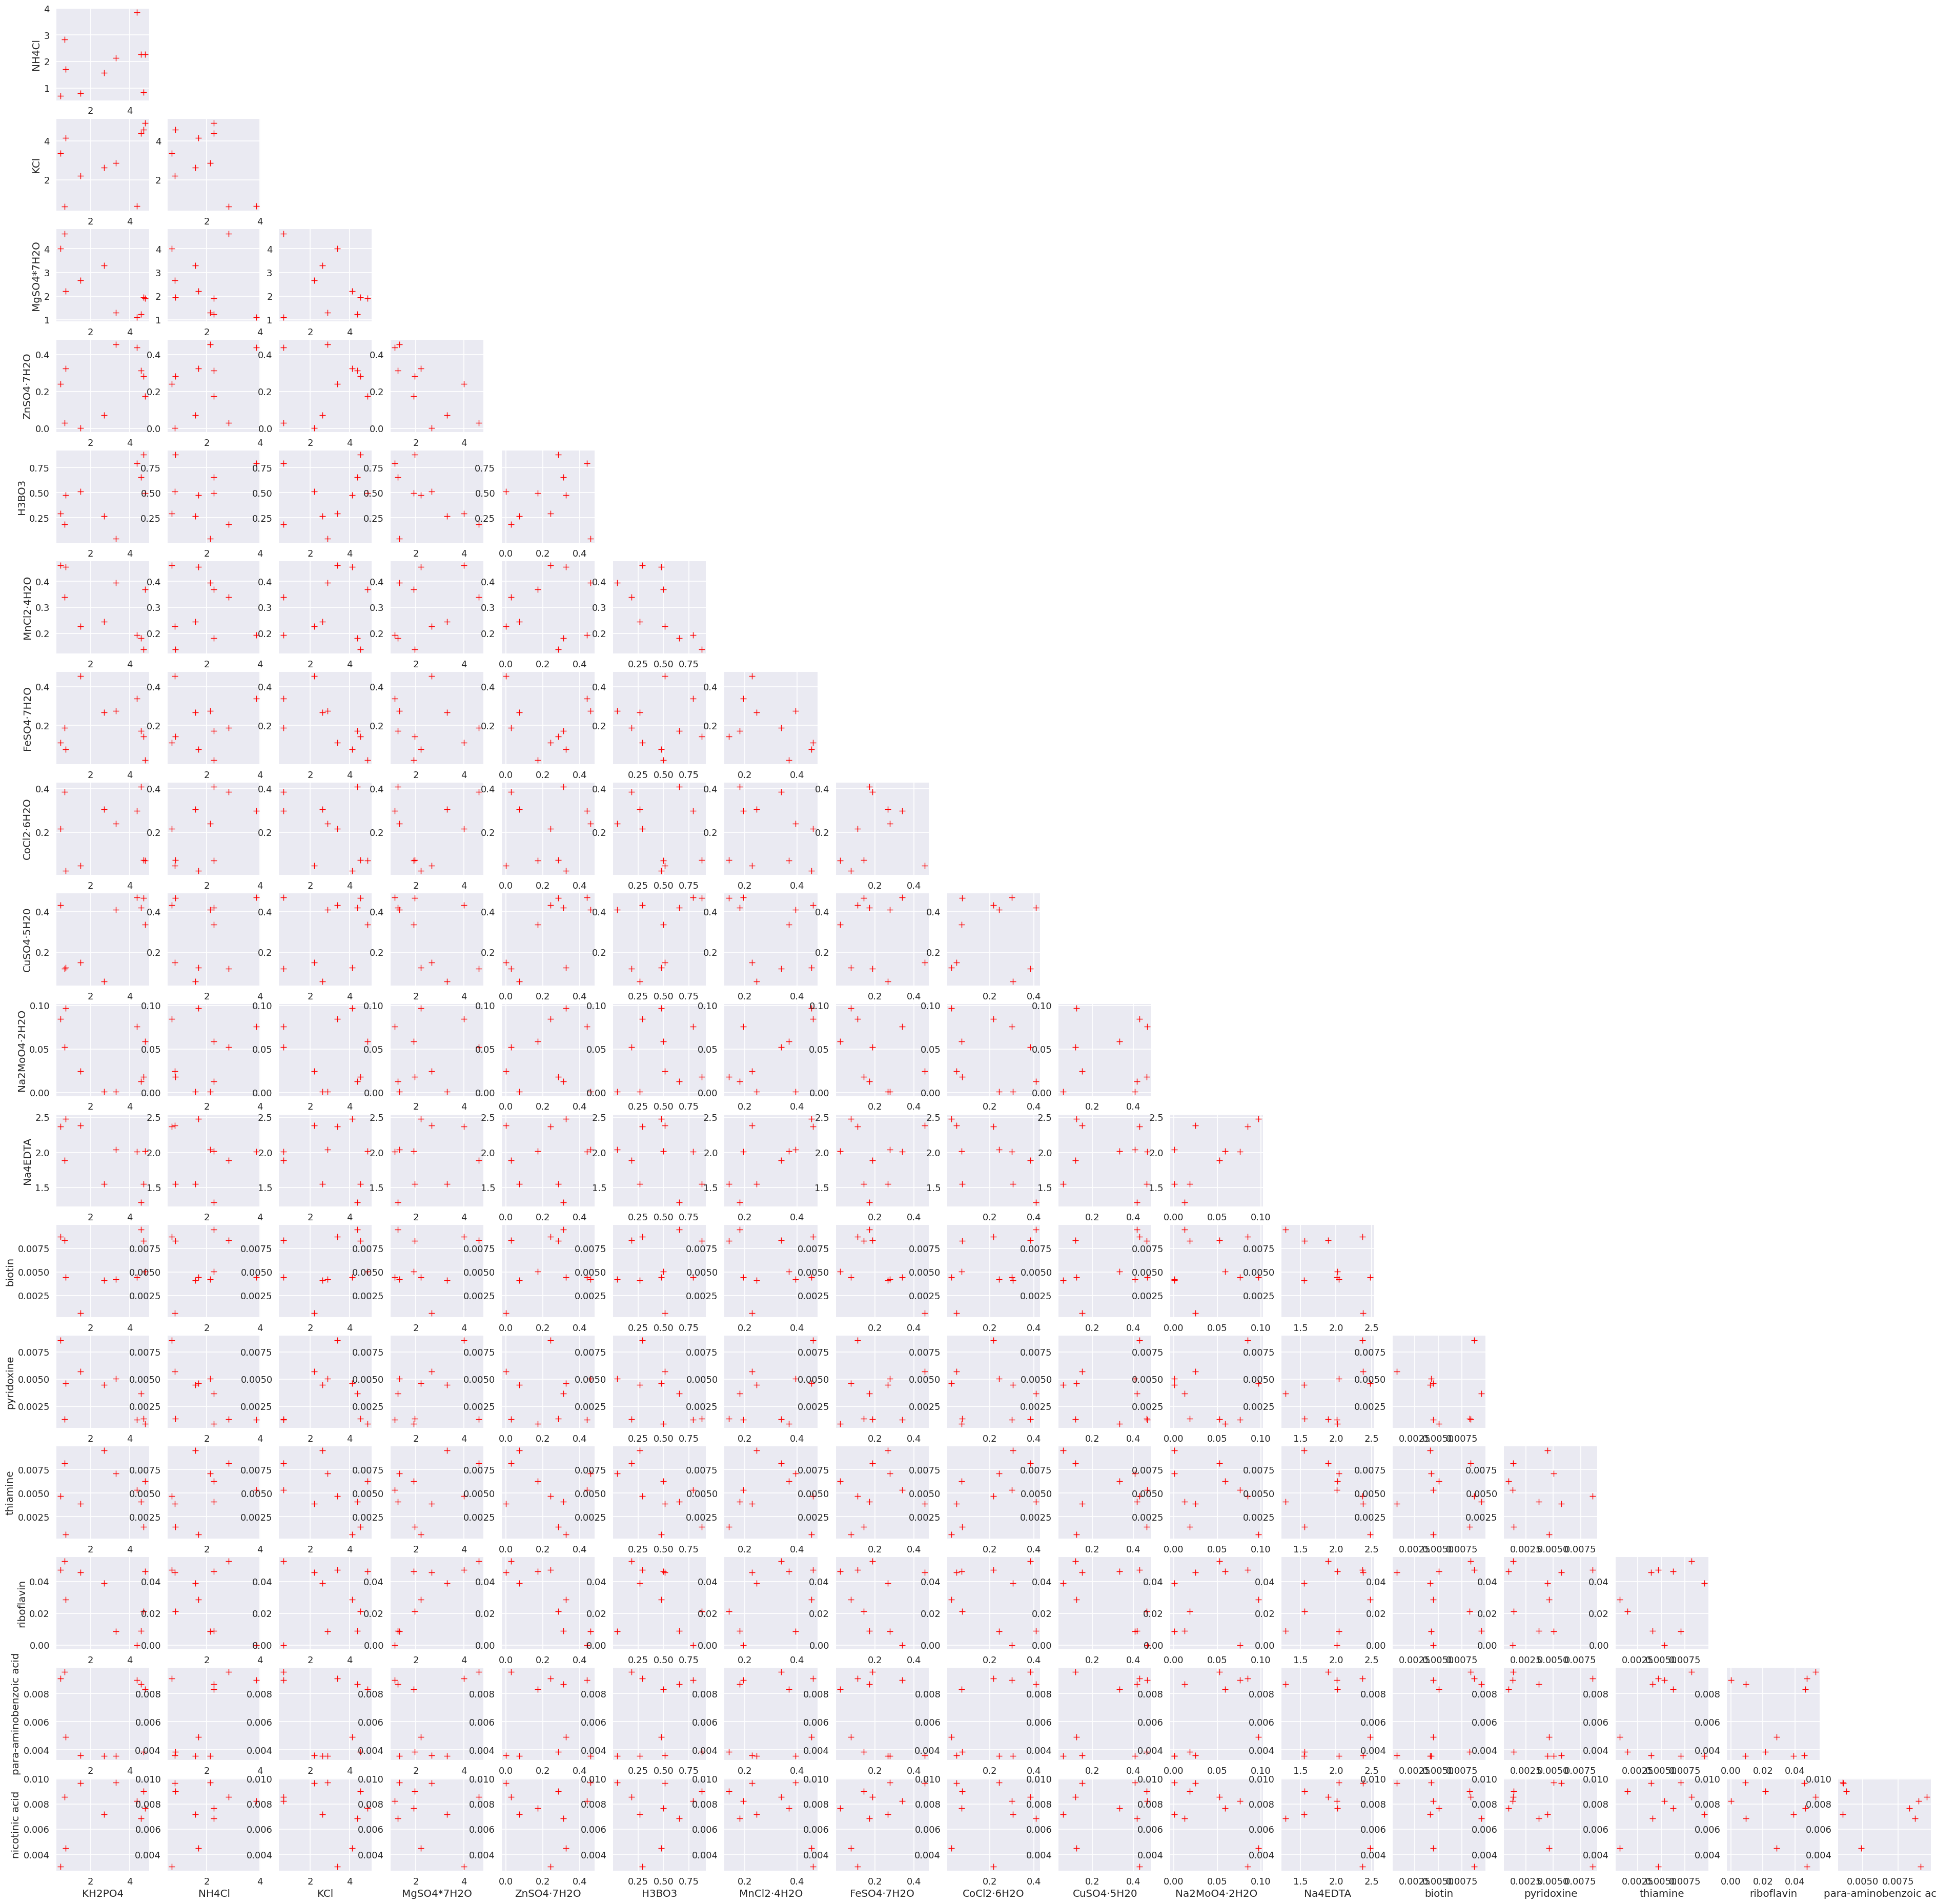

In [61]:
designs_pairwise(art, df_rec_explor)

In [62]:
df_rec = (df_rec_explor.copy())

In [63]:
# df_rec = df_rec.rename(columns={"Malate titer (g/L)": "Malate titer (g/L) prediction"})


# Check the distribution of designs

Define dataframe with train data and predictions:


In [64]:
df_train = DBTL_results[user_params['components']]
df_train['Malate Titer (g/L)'] = DBTL_results['Malate Titer (g/L)']

In [65]:
df_train

,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,CuSO4·5H20,Na2MoO4·2H2O,Na4EDTA,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid,Malate Titer (g/L)
0,3.980770,2.726696,3.101909,3.564820,0.342065,0.266442,0.266025,0.148381,0.168819,0.217547,0.049863,2.022302,0.000014,0.002962,0.003923,0.029026,0.004538,0.002338,2.38
1,3.980770,2.726696,3.101909,3.564820,0.342065,0.266442,0.266025,0.148381,0.168819,0.217547,0.049863,2.022302,0.000014,0.002962,0.003923,0.029026,0.004538,0.002338,2.43
2,3.980770,2.726696,3.101909,3.564820,0.342065,0.266442,0.266025,0.148381,0.168819,0.217547,0.049863,2.022302,0.000014,0.002962,0.003923,0.029026,0.004538,0.002338,2.49
3,0.463416,1.202824,3.487949,2.090830,0.002133,0.641487,0.364212,0.470553,0.419028,0.001260,0.063478,1.973034,0.000503,0.000812,0.003438,0.000026,0.007167,0.007175,0.07
4,0.463416,1.202824,3.487949,2.090830,0.002133,0.641487,0.364212,0.470553,0.419028,0.001260,0.063478,1.973034,0.000503,0.000812,0.003438,0.000026,0.007167,0.007175,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,4.619793,3.180391,3.814341,0.280609,0.237304,0.879325,0.435048,0.354152,0.088065,0.487628,0.089010,2.058640,0.009972,0.009589,0.003318,0.018708,0.001813,0.006659,1.00
257,4.619793,3.180391,3.814341,0.280609,0.237304,0.879325,0.435048,0.354152,0.088065,0.487628,0.089010,2.058640,0.009972,0.009589,0.003318,0.018708,0.001813,0.006659,1.00
258,4.291071,4.091897,1.321019,0.299799,0.411875,0.080135,0.468360,0.114329,0.357079,0.361906,0.069739,0.913847,0.008394,0.000311,0.002309,0.044397,0.006925,0.005050,1.00
259,4.291071,4.091897,1.321019,0.299799,0.411875,0.080135,0.468360,0.114329,0.357079,0.361906,0.069739,0.913847,0.008394,0.000311,0.002309,0.044397,0.006925,0.005050,1.00




Add predictions, cv-predictions and standard deviation of the OD600 predictions:


In [66]:
train_predicted_mean, train_predicted_std = art.post_pred_stats(
            df_train.values[:, :-1]
        )

In [67]:
df_train['Malate_pred'] = train_predicted_mean
df_train['Malate_std'] = train_predicted_std
df_train['Malate_cv_pred'] = art.model_df_cv[0]["Predictions"]["Ensemble Model"]
df_train['Malate_cv_std'] = art.model_df_cv[0]["Predictions StDev"]["Ensemble Model"]

Add label for control lines:

In [68]:

df_stand = pd.read_csv(user_params['standard_media_file']).set_index("Ingrediant")
df_train['Label'] = 'train'
# df_train.loc[control_lines.index, 'Label'] = 'standard'



In [69]:
df_train

,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,CuSO4·5H20,...,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid,Malate Titer (g/L),Malate_pred,Malate_std,Malate_cv_pred,Malate_cv_std,Label
0,3.980770,2.726696,3.101909,3.564820,0.342065,0.266442,0.266025,0.148381,0.168819,0.217547,...,0.003923,0.029026,0.004538,0.002338,2.38,2.320598,2.066952,0.771118,2.563932,train
1,3.980770,2.726696,3.101909,3.564820,0.342065,0.266442,0.266025,0.148381,0.168819,0.217547,...,0.003923,0.029026,0.004538,0.002338,2.43,2.320598,2.066952,0.771118,2.563932,train
2,3.980770,2.726696,3.101909,3.564820,0.342065,0.266442,0.266025,0.148381,0.168819,0.217547,...,0.003923,0.029026,0.004538,0.002338,2.49,2.320598,2.066952,0.771118,2.563932,train
3,0.463416,1.202824,3.487949,2.090830,0.002133,0.641487,0.364212,0.470553,0.419028,0.001260,...,0.003438,0.000026,0.007167,0.007175,0.07,0.074111,2.066193,1.149627,2.644986,train
4,0.463416,1.202824,3.487949,2.090830,0.002133,0.641487,0.364212,0.470553,0.419028,0.001260,...,0.003438,0.000026,0.007167,0.007175,0.07,0.074111,2.066193,1.149627,2.644986,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,4.619793,3.180391,3.814341,0.280609,0.237304,0.879325,0.435048,0.354152,0.088065,0.487628,...,0.003318,0.018708,0.001813,0.006659,1.00,1.101171,2.068841,0.755757,2.312136,train
257,4.619793,3.180391,3.814341,0.280609,0.237304,0.879325,0.435048,0.354152,0.088065,0.487628,...,0.003318,0.018708,0.001813,0.006659,1.00,1.101171,2.068841,0.755757,2.312136,train
258,4.291071,4.091897,1.321019,0.299799,0.411875,0.080135,0.468360,0.114329,0.357079,0.361906,...,0.002309,0.044397,0.006925,0.005050,1.00,1.105354,2.068626,1.237667,2.456971,train
259,4.291071,4.091897,1.321019,0.299799,0.411875,0.080135,0.468360,0.114329,0.357079,0.361906,...,0.002309,0.044397,0.006925,0.005050,1.00,1.105354,2.068626,1.237667,2.456971,train


save the control data set for this cycle:

In [70]:


file = f"{user_params['output_file_path']}/train_pred.csv"
df_train.to_csv(file)



In [71]:
# df_stand.values.T[:,3]

In [72]:
df_train.loc[78,:]

KH2PO4                    4.087562
NH4Cl                     2.131518
KCl                        2.83772
MgSO4*7H2O                2.355412
ZnSO4·7H2O                0.425586
H3BO3                     1.040215
MnCl2·4H2O                0.005711
FeSO4·7H2O                0.002432
CoCl2·6H2O                0.134524
CuSO4·5H20                0.388366
Na2MoO4·2H2O              0.077741
Na4EDTA                   2.260173
biotin                    0.007791
pyridoxine                0.000308
thiamine                  0.004017
riboflavin                0.001244
para-aminobenzoic acid    0.000074
nicotinic acid            0.000081
Malate Titer (g/L)             0.0
Malate_pred               0.009528
Malate_std                2.066187
Malate_cv_pred            1.151901
Malate_cv_std             2.456494
Label                        train
Name: 78, dtype: object

In [73]:
X_train = df_train[user_params['components']].values
X_train[77,:]

array([1.50e+00, 1.43e+00, 5.00e-01, 5.00e-01, 2.25e-03, 1.10e-02,
       5.00e-03, 5.00e-03, 1.70e-03, 1.60e-03, 8.50e-05, 5.00e-03,
       1.00e-04, 1.00e-04, 1.00e-04, 1.00e-04, 1.00e-04, 1.00e-04])

In [74]:
def designs_pairwise(art, df_rec, user_params, df_stand, df_train=None):

    dim = art.num_input_var

    plt.style.use('seaborn-whitegrid')

    fig = plt.figure(figsize=(35, 35))
    fig.patch.set_facecolor("white")

    X = df_rec[user_params['components']].values
    X_train = df_train[user_params['components']].values
    standard = df_stand.values.T

    for var1 in range(dim):
        for var2 in range(var1 + 1, dim):

            ax = fig.add_subplot(dim, dim, (var2 * dim + var1 + 1))
            ax.scatter(
                X_train[:, var1],
                X_train[:, var2],
                c="r",
                marker=".",
                s=150*df_train['Malate Titer (g/L)'],
                lw=1,
                label="Train data",
            )
            
#             ax.scatter(
#                 standard[:, var1],
#                 standard[:, var2],
#                 c="k",
#                 marker=".",
#                 s=150*standard[:, -1].astype(float),
#                 lw=1,
#                 label="Standard",
#             )
            
            ax.scatter(
                X[:, var1],
                X[:, var2],
                c="g",
                marker=".",
                s=150*df_rec['Malate Titer (g/L) mean'],
                lw=1,
                label="Recommendations",
            )
            
            ax.scatter(
                X_train[77, var1],
                X_train[77, var2],
                c="k",
                marker=".",
                s=150*df_rec['Malate Titer (g/L) mean'].values[-1],
                lw=1,
                label="Standard",
            )
            
            
                        
            if var2 == (dim - 1):
                ax.set_xlabel(art.input_vars[var1])
            if var1 == 0:
                ax.set_ylabel(art.input_vars[var2])
                if var2 == 0:
                    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), shadow=True)

                    
    fig.savefig(
        f'{art.outDir}/designs_pairwise_26.png',
        bbox_inches="tight",
        transparent=False, 
        dpi=300
    )



Red are train data, green are recommendations, black are standards


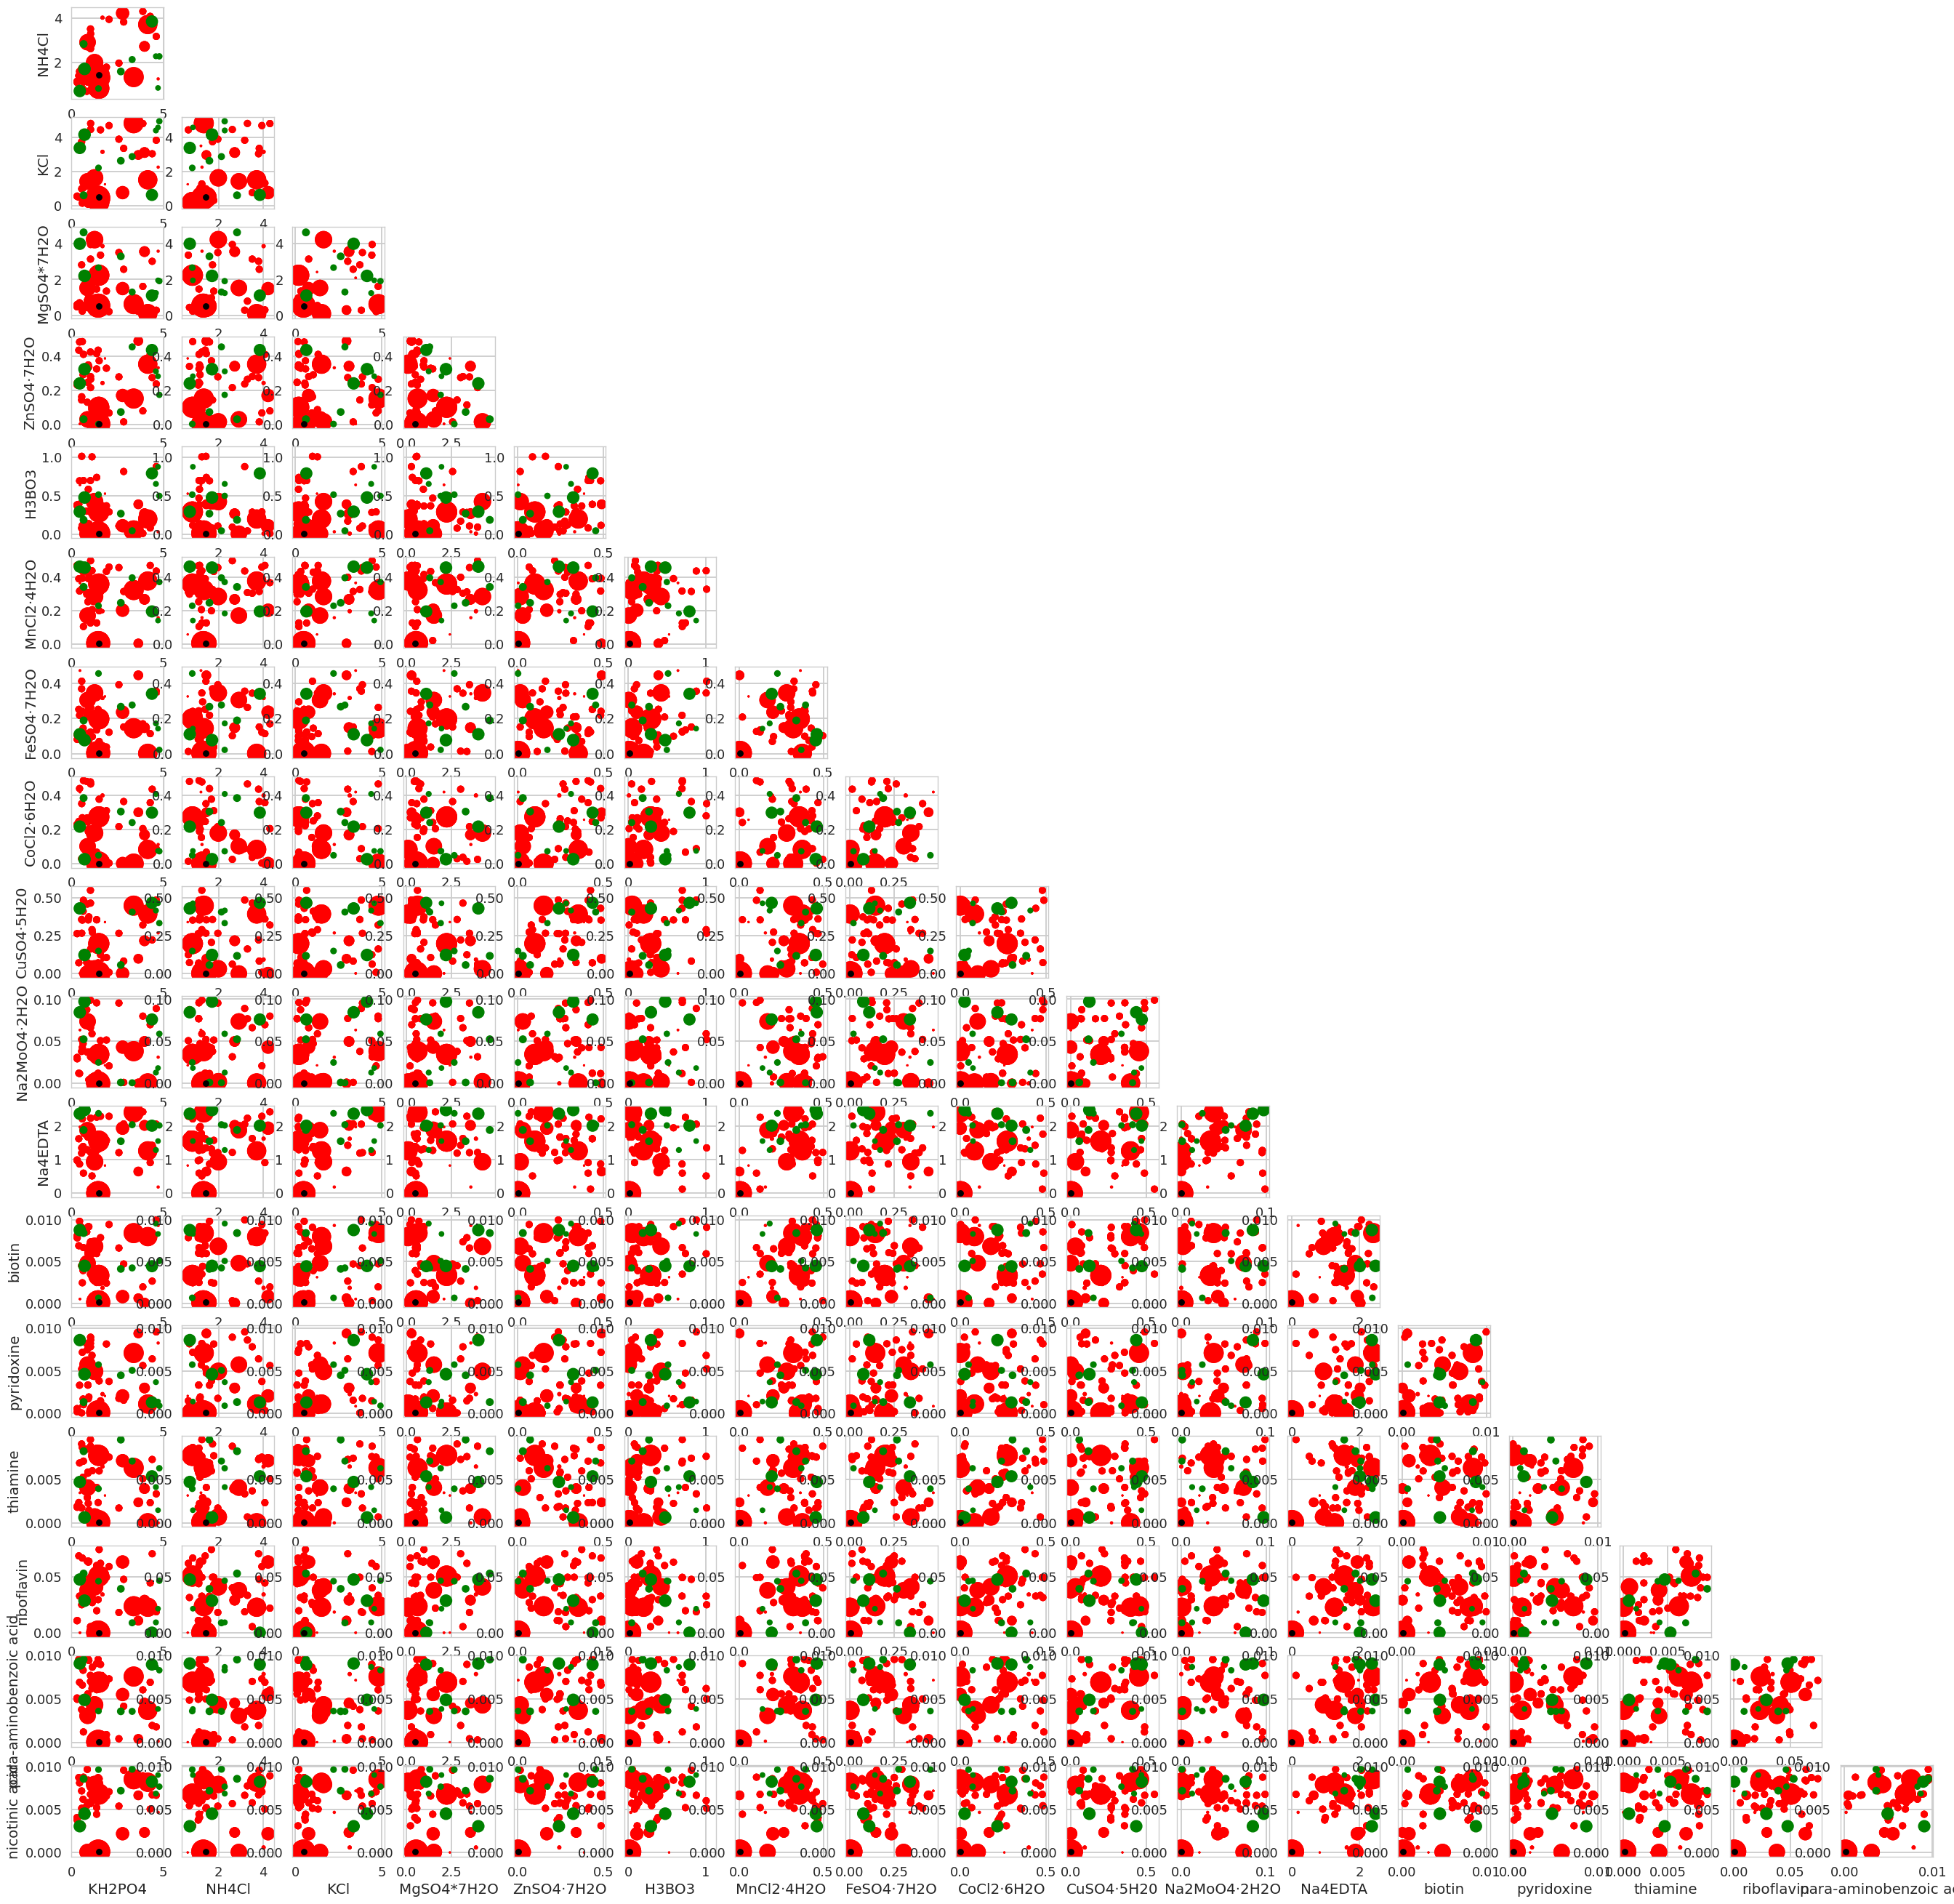

In [75]:
designs_pairwise(art, df_rec, user_params, df_stand,df_train)

In [76]:
df_rec

,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,CuSO4·5H20,...,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid,Malate Titer (g/L),Malate Titer (g/L) mean,Malate Titer (g/L) std,Label
0,4.715872,0.835929,4.557331,1.953778,0.283068,0.877251,0.139454,0.142752,0.074789,0.466199,...,0.008293,0.001365,0.001448,0.021424,0.003865,0.009016,0.567682,0.567682,2.086325,exploration
1,3.307102,2.127971,2.864732,1.299409,0.456020,0.043591,0.394603,0.275901,0.240586,0.407918,...,0.004222,0.005046,0.007061,0.008861,0.003591,0.009693,0.961562,0.961562,2.085887,exploration
2,4.600939,2.277247,4.382520,1.241922,0.311666,0.653661,0.182087,0.172074,0.408142,0.417694,...,0.009533,0.003658,0.004089,0.009239,0.008680,0.006855,0.640354,0.640354,2.085313,exploration
3,0.712971,1.701991,4.140557,2.203677,0.324425,0.477065,0.455215,0.077644,0.026307,0.123170,...,0.004467,0.004596,0.000621,0.028608,0.004911,0.004515,3.519268,3.519268,2.083853,exploration
4,4.385339,3.862647,0.638906,1.104319,0.437863,0.790959,0.193977,0.339253,0.298684,0.468898,...,0.004430,0.001261,0.005332,0.000109,0.008959,0.008239,3.293892,3.293892,2.083372,exploration
5,1.472850,0.808603,2.208736,2.665660,0.001284,0.513783,0.227719,0.454090,0.049220,0.149756,...,0.000641,0.005724,0.003904,0.045972,0.003627,0.009648,0.835062,0.835062,2.083262,exploration
6,0.454033,0.696805,3.368887,4.003595,0.240726,0.292176,0.461282,0.110994,0.216912,0.432028,...,0.008757,0.008620,0.004676,0.047503,0.009078,0.003057,3.425689,3.425689,2.083122,exploration
7,2.689874,1.584316,2.622409,3.297719,0.072180,0.266914,0.245467,0.266466,0.304795,0.056756,...,0.004105,0.004463,0.009506,0.039201,0.003596,0.007191,1.187320,1.187320,2.082445,exploration
8,0.662274,2.833784,0.614860,4.641454,0.029426,0.185312,0.339922,0.188752,0.384102,0.117362,...,0.008398,0.001302,0.008192,0.052839,0.009530,0.008576,1.249064,1.249064,2.081945,exploration
9,4.787841,2.273611,4.918181,1.911206,0.173273,0.497979,0.369308,0.022546,0.072779,0.334385,...,0.005055,0.000872,0.006246,0.046389,0.008306,0.007664,0.760977,0.760977,2.081350,exploration



## Saving the generated designs

include all replicates:

In [77]:
df_rec_wells = df_rec.loc[df_rec.index.repeat(3)]

In [78]:
df_rec_wells

,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,CuSO4·5H20,...,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid,Malate Titer (g/L),Malate Titer (g/L) mean,Malate Titer (g/L) std,Label
0,4.715872,0.835929,4.557331,1.953778,0.283068,0.877251,0.139454,0.142752,0.074789,0.466199,...,0.008293,0.001365,0.001448,0.021424,0.003865,0.009016,0.567682,0.567682,2.086325,exploration
0,4.715872,0.835929,4.557331,1.953778,0.283068,0.877251,0.139454,0.142752,0.074789,0.466199,...,0.008293,0.001365,0.001448,0.021424,0.003865,0.009016,0.567682,0.567682,2.086325,exploration
0,4.715872,0.835929,4.557331,1.953778,0.283068,0.877251,0.139454,0.142752,0.074789,0.466199,...,0.008293,0.001365,0.001448,0.021424,0.003865,0.009016,0.567682,0.567682,2.086325,exploration
1,3.307102,2.127971,2.864732,1.299409,0.456020,0.043591,0.394603,0.275901,0.240586,0.407918,...,0.004222,0.005046,0.007061,0.008861,0.003591,0.009693,0.961562,0.961562,2.085887,exploration
1,3.307102,2.127971,2.864732,1.299409,0.456020,0.043591,0.394603,0.275901,0.240586,0.407918,...,0.004222,0.005046,0.007061,0.008861,0.003591,0.009693,0.961562,0.961562,2.085887,exploration
1,3.307102,2.127971,2.864732,1.299409,0.456020,0.043591,0.394603,0.275901,0.240586,0.407918,...,0.004222,0.005046,0.007061,0.008861,0.003591,0.009693,0.961562,0.961562,2.085887,exploration
2,4.600939,2.277247,4.382520,1.241922,0.311666,0.653661,0.182087,0.172074,0.408142,0.417694,...,0.009533,0.003658,0.004089,0.009239,0.008680,0.006855,0.640354,0.640354,2.085313,exploration
2,4.600939,2.277247,4.382520,1.241922,0.311666,0.653661,0.182087,0.172074,0.408142,0.417694,...,0.009533,0.003658,0.004089,0.009239,0.008680,0.006855,0.640354,0.640354,2.085313,exploration
2,4.600939,2.277247,4.382520,1.241922,0.311666,0.653661,0.182087,0.172074,0.408142,0.417694,...,0.009533,0.003658,0.004089,0.009239,0.008680,0.006855,0.640354,0.640354,2.085313,exploration
3,0.712971,1.701991,4.140557,2.203677,0.324425,0.477065,0.455215,0.077644,0.026307,0.123170,...,0.004467,0.004596,0.000621,0.028608,0.004911,0.004515,3.519268,3.519268,2.083853,exploration




Rename index to well names:


In [79]:
well_rows = 'ABCDEFGHIJ'
well_columns = '123'


In [80]:
well_names = [f'{row}{column}'  for row in well_rows for column in well_columns ]

df_rec_wells['Well'] = well_names
df_rec_wells = df_rec_wells.set_index(['Well'])
df_rec_wells


,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,CuSO4·5H20,...,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid,Malate Titer (g/L),Malate Titer (g/L) mean,Malate Titer (g/L) std,Label
Well,,,,,,,,,,,,,,,,,,,,,
A1,4.715872,0.835929,4.557331,1.953778,0.283068,0.877251,0.139454,0.142752,0.074789,0.466199,...,0.008293,0.001365,0.001448,0.021424,0.003865,0.009016,0.567682,0.567682,2.086325,exploration
A2,4.715872,0.835929,4.557331,1.953778,0.283068,0.877251,0.139454,0.142752,0.074789,0.466199,...,0.008293,0.001365,0.001448,0.021424,0.003865,0.009016,0.567682,0.567682,2.086325,exploration
A3,4.715872,0.835929,4.557331,1.953778,0.283068,0.877251,0.139454,0.142752,0.074789,0.466199,...,0.008293,0.001365,0.001448,0.021424,0.003865,0.009016,0.567682,0.567682,2.086325,exploration
B1,3.307102,2.127971,2.864732,1.299409,0.456020,0.043591,0.394603,0.275901,0.240586,0.407918,...,0.004222,0.005046,0.007061,0.008861,0.003591,0.009693,0.961562,0.961562,2.085887,exploration
B2,3.307102,2.127971,2.864732,1.299409,0.456020,0.043591,0.394603,0.275901,0.240586,0.407918,...,0.004222,0.005046,0.007061,0.008861,0.003591,0.009693,0.961562,0.961562,2.085887,exploration
B3,3.307102,2.127971,2.864732,1.299409,0.456020,0.043591,0.394603,0.275901,0.240586,0.407918,...,0.004222,0.005046,0.007061,0.008861,0.003591,0.009693,0.961562,0.961562,2.085887,exploration
C1,4.600939,2.277247,4.382520,1.241922,0.311666,0.653661,0.182087,0.172074,0.408142,0.417694,...,0.009533,0.003658,0.004089,0.009239,0.008680,0.006855,0.640354,0.640354,2.085313,exploration
C2,4.600939,2.277247,4.382520,1.241922,0.311666,0.653661,0.182087,0.172074,0.408142,0.417694,...,0.009533,0.003658,0.004089,0.009239,0.008680,0.006855,0.640354,0.640354,2.085313,exploration
C3,4.600939,2.277247,4.382520,1.241922,0.311666,0.653661,0.182087,0.172074,0.408142,0.417694,...,0.009533,0.003658,0.004089,0.009239,0.008680,0.006855,0.640354,0.640354,2.085313,exploration


In [81]:
file = f"{user_params['output_file_path']}/target_concentrations_26.csv"
df_rec.to_csv(file) # This file will be used for the computation of volume transfers and data analysis
file = f"{user_params['output_file_path']}/target_concentrations_wells_26.csv"

df_rec_wells.to_csv(file) # This file will be used for the computation of volume transfers and data analysis
